전처리는 배나연님의 EDA 코드를 그대로 추가함.  

### 데이터3 EDA&전처리 내용

1. row 1941개, 중복값 없음, 결측치 없음  
2. 독립변수 27개 중 범주형 3개(['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index']) -> 변수 갯수에 비해 데이터 수가 적음  
        - Outside_Global_Index 컬럼에 대해 원핫 인코딩 적용  
        - type of steel 300/400 컬럼을 1개로 통일(0이면 300,1이면 400)  
        - +PCA 고려해봤으나, 신경망을 사용할 경우 dense layer에 입력값을 조정하면 차원 축소한 것과 같은 효과를 보이므로 여기에서는 PCA하지 않음. 다만, 신경망 모델을   사용하지 않을 시 차원 축소 기법 적용 필요  
3. target변수 7개이며, class 비율이 2.8% 부터 34.7% 까지 존재 => 추후 샘플링 기법 적용 필요  
4. 이상치가 다수 존재 -> 바이올린 플롯으로 시각화, 맥스값으로 클립  
5. skewed data에 대해 로그변환  
7. 표준화  : 이 파일로 전처리된 데이터에 샘플링(+차원축소), 모델 학습&하이퍼파라미터 튜닝 작업 필요  

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [2]:
data = pd.read_csv('./csv/multi_classification_data.csv')

In [3]:
# 중복항 존재 여부
print(f'\n 중복항 존재여부 : {data.duplicated().any()}\n')


 중복항 존재여부 : False



In [4]:
# 하자가 없는 row가 있는지 확인
print(f'하자없는 row : {data.iloc[:,27:].apply(lambda row: not (row == 1).any(), axis=1).any()}')

하자없는 row : False


target class rate


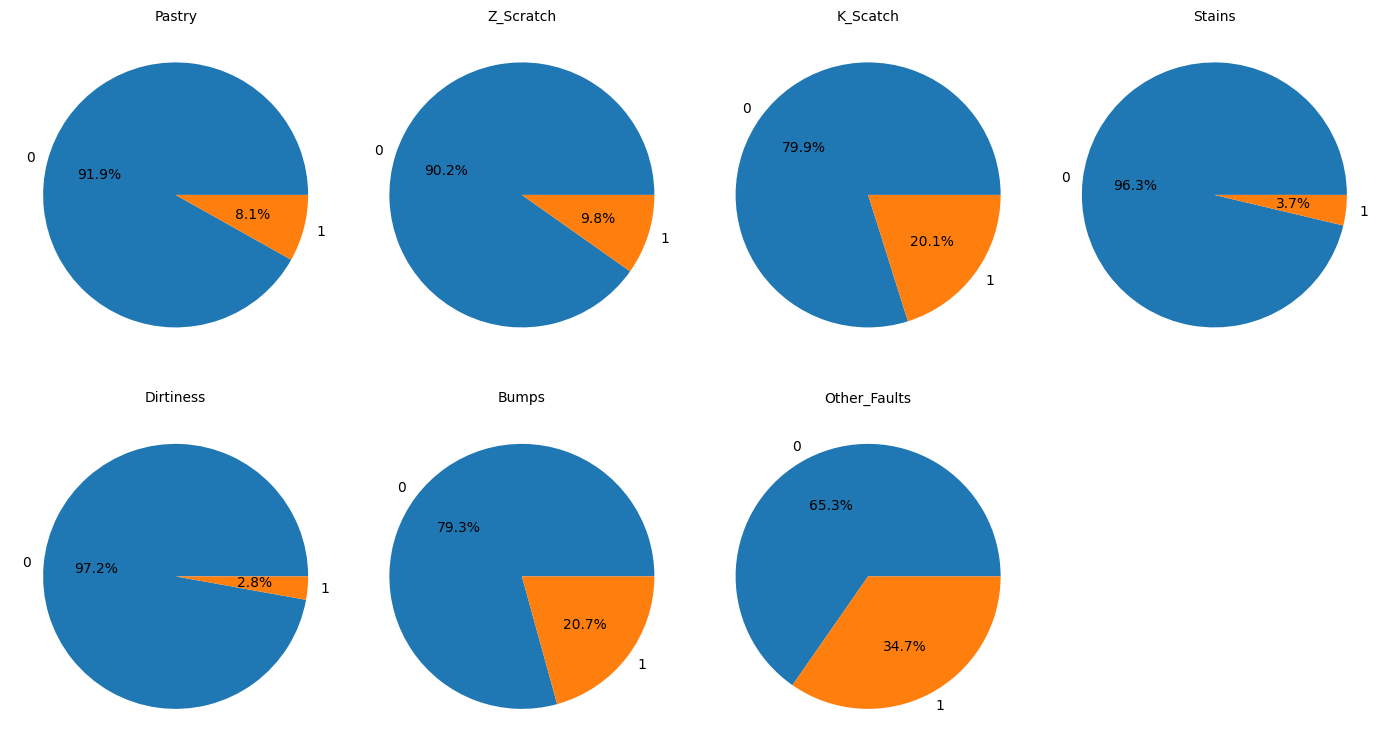

In [6]:
print('target class rate')
fig = plt.figure(figsize=(14,8))
x = 0
for i in data.iloc[:,27:].columns:
    x += 1
    temp = data[i].value_counts()
    ax = fig.add_subplot(240+x)
    ax.pie(temp, labels=[0,1], autopct='%1.1f%%')
    ax.set_title(i, fontsize=10)
plt.tight_layout()
plt.show()

In [7]:
data.describe()

X_Minimum    X_Maximum     Y_Minimum     Y_Maximum   Pixels_Areas  \
count  1941.000000  1941.000000  1.941000e+03  1.941000e+03    1941.000000   
mean    571.136012   617.964451  1.650685e+06  1.650739e+06    1893.878413   
std     520.690671   497.627410  1.774578e+06  1.774590e+06    5168.459560   
min       0.000000     4.000000  6.712000e+03  6.724000e+03       2.000000   
25%      51.000000   192.000000  4.712530e+05  4.712810e+05      84.000000   
50%     435.000000   467.000000  1.204128e+06  1.204136e+06     174.000000   
75%    1053.000000  1072.000000  2.183073e+06  2.183084e+06     822.000000   
max    1705.000000  1713.000000  1.298766e+07  1.298769e+07  152655.000000   

        X_Perimeter   Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
count   1941.000000   1941.000000       1.941000e+03            1941.000000   
mean     111.855229     82.965997       2.063121e+05              84.548686   
std      301.209187    426.482879       5.122936e+05              32.134276   
min        2.000000      1.000000       2.500000e+02               0.000000   
25%       15.000000     13.000000       9.522000e+03              63.000000   
50%       26.000000     25.000000       1.920200e+04              90.000000   
75%       84.000000     83.000000       8.301100e+04             106.000000   
max    10449.000000  18152.000000       1.159141e+07             203.000000   

       Maximum_of_Luminosity  ...  Orientation_Index  Luminosity_Index  \
count            1941.000000  ...        1941.000000       1941.000000   
mean              130.193715  ...           0.083288         -0.131305   
std                18.690992  ...           0.500868          0.148767   
min                37.000000  ...          -0.991000         -0.998900   
25%               124.000000  ...          -0.333300         -0.195000   
50%               127.000000  ...           0.095200         -0.133000   
75%               140.000000  ...           0.511600         -0.066600   
max               253.000000  ...           0.991700          0.642100   

       SigmoidOfAreas       Pastry    Z_Scratch     K_Scatch       Stains  \
count     1941.000000  1941.000000  1941.000000  1941.000000  1941.000000   
mean         0.585420     0.081401     0.097888     0.201443     0.037094   
std          0.339452     0.273521     0.297239     0.401181     0.189042   
min          0.119000     0.000000     0.000000     0.000000     0.000000   
25%          0.248200     0.000000     0.000000     0.000000     0.000000   
50%          0.506300     0.000000     0.000000     0.000000     0.000000   
75%          0.999800     0.000000     0.000000     0.000000     0.000000   
max          1.000000     1.000000     1.000000     1.000000     1.000000   

         Dirtiness        Bumps  Other_Faults  
count  1941.000000  1941.000000   1941.000000  
mean      0.028336     0.207110      0.346728  
std       0.165973     0.405339      0.476051  
min       0.000000     0.000000      0.000000  
25%       0.000000     0.000000      0.000000  
50%       0.000000     0.000000      0.000000  
75%       0.000000     0.000000      1.000000  
max       1.000000     1.000000      1.000000  

[8 rows x 34 columns]

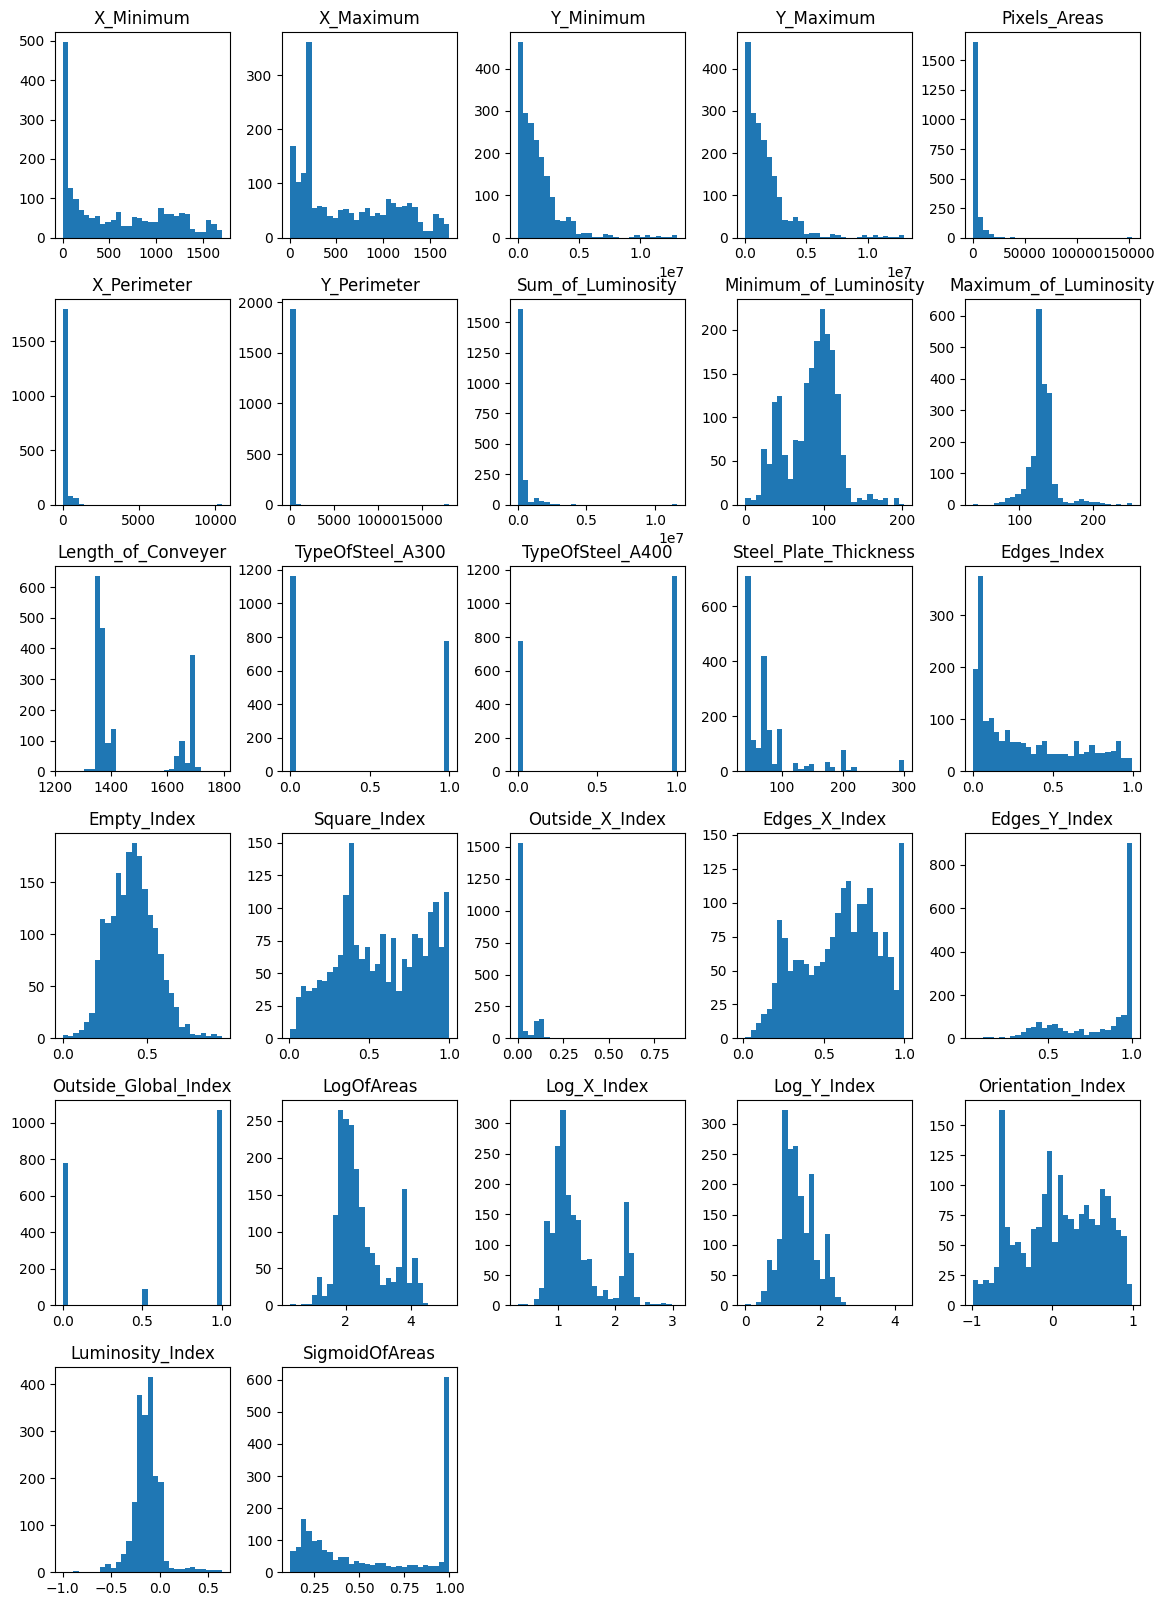

In [8]:
# 데이터 분포 확인
data.iloc[:,:27].hist(bins=30, figsize=(14,20), grid=False)
plt.show()

# Pixels_Areas, X_Perimeter, Y_Perimeter, Sum_of_Luminosity 아웃라이어 존재

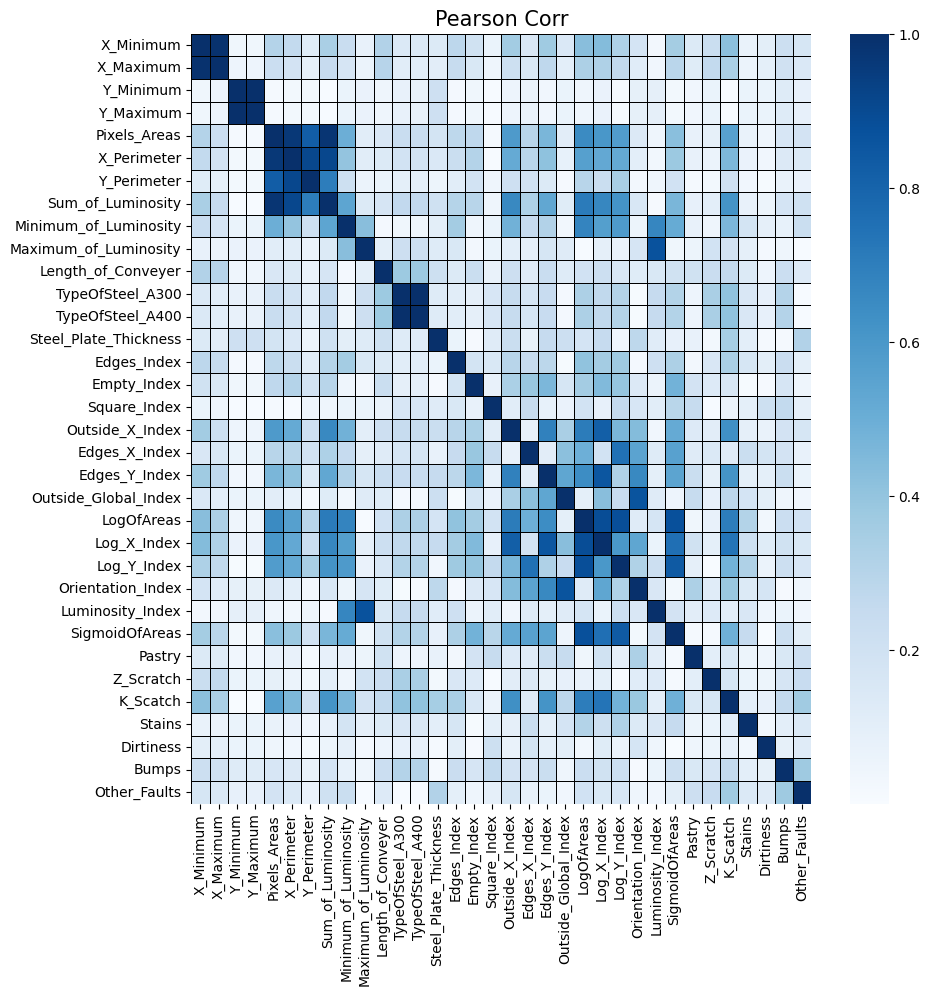

In [9]:
# 상관계수 확인
plt.figure(figsize=(10,10))
sns.heatmap(data.corr().abs(), cmap='Blues', linewidths=0.4, linecolor='black')
plt.title('Pearson Corr', fontsize=15)
plt.show()

In [10]:
# X, Y의 min max는 상관계수 1
# TypeOfSteel 300/400은 상관계수 1 => 같은 것을 말하고 있는 컬럼이므로 둘 중 1개를 드랍

data['TypeOfSteel'] = data['TypeOfSteel_A300']
data = data.drop(['TypeOfSteel_A300', 'TypeOfSteel_A400'], axis=1)

In [11]:
# Outside_Global_Index 컬럼에 대해 원핫 인코딩 수행

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(data[['Outside_Global_Index']])

df_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(['Outside_Global_Index']))

# 원핫 인코딩 결과를 원래 데이터프레임에 합칠 수도 있습니다.
df_encoded = pd.concat([data, df_encoded], axis=1)
df_encoded = df_encoded.drop('Outside_Global_Index', axis=1)

df_encoded

c:\ProgramData\anaconda3\envs\TeamProject\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0            42         50     270900     270944           267           17   
1           645        651    2538079    2538108           108           10   
2           829        835    1553913    1553931            71            8   
3           853        860     369370     369415           176           13   
4          1289       1306     498078     498335          2409           60   
...         ...        ...        ...        ...           ...          ...   
1936        249        277     325780     325796           273           54   
1937        144        175     340581     340598           287           44   
1938        145        174     386779     386794           292           40   
1939        137        170     422497     422528           419           97   
1940       1261       1281      87951      87967           103           26   

      Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0              44              24220                     76   
1              30              11397                     84   
2              19               7972                     99   
3              45              18996                     99   
4             260             246930                     37   
...           ...                ...                    ...   
1936           22              35033                    119   
1937           24              34599                    112   
1938           22              37572                    120   
1939           47              52715                    117   
1940           22              11682                    101   

      Maximum_of_Luminosity  ...  Z_Scratch  K_Scatch  Stains  Dirtiness  \
0                       108  ...          0         0       0          0   
1                       123  ...          0         0       0          0   
2                       125  ...          0         0       0          0   
3                       126  ...          0         0       0          0   
4                       126  ...          0         0       0          0   
...                     ...  ...        ...       ...     ...        ...   
1936                    141  ...          0         0       0          0   
1937                    133  ...          0         0       0          0   
1938                    140  ...          0         0       0          0   
1939                    140  ...          0         0       0          0   
1940                    133  ...          0         0       0          0   

      Bumps  Other_Faults  TypeOfSteel  Outside_Global_Index_0.0  \
0         0             0            1                       0.0   
1         0             0            1                       0.0   
2         0             0            1                       0.0   
3         0             0            0                       0.0   
4         0             0            0                       0.0   
...     ...           ...          ...                       ...   
1936      0             1            0                       1.0   
1937      0             1            0                       1.0   
1938      0             1            0                       1.0   
1939      0             1            0                       1.0   
1940      0             1            1                       1.0   

      Outside_Global_Index_0.5  Outside_Global_Index_1.0  
0                          0.0                       1.0  
1                          0.0                       1.0  
2                          0.0                       1.0  
3                          0.0                       1.0  
4                          0.0                       1.0  
...                        ...                       ...  
1936                       0.0                       0.0  
1937                       0.0                       0.0  
1938                       0.0         

### 바이올린 플롯

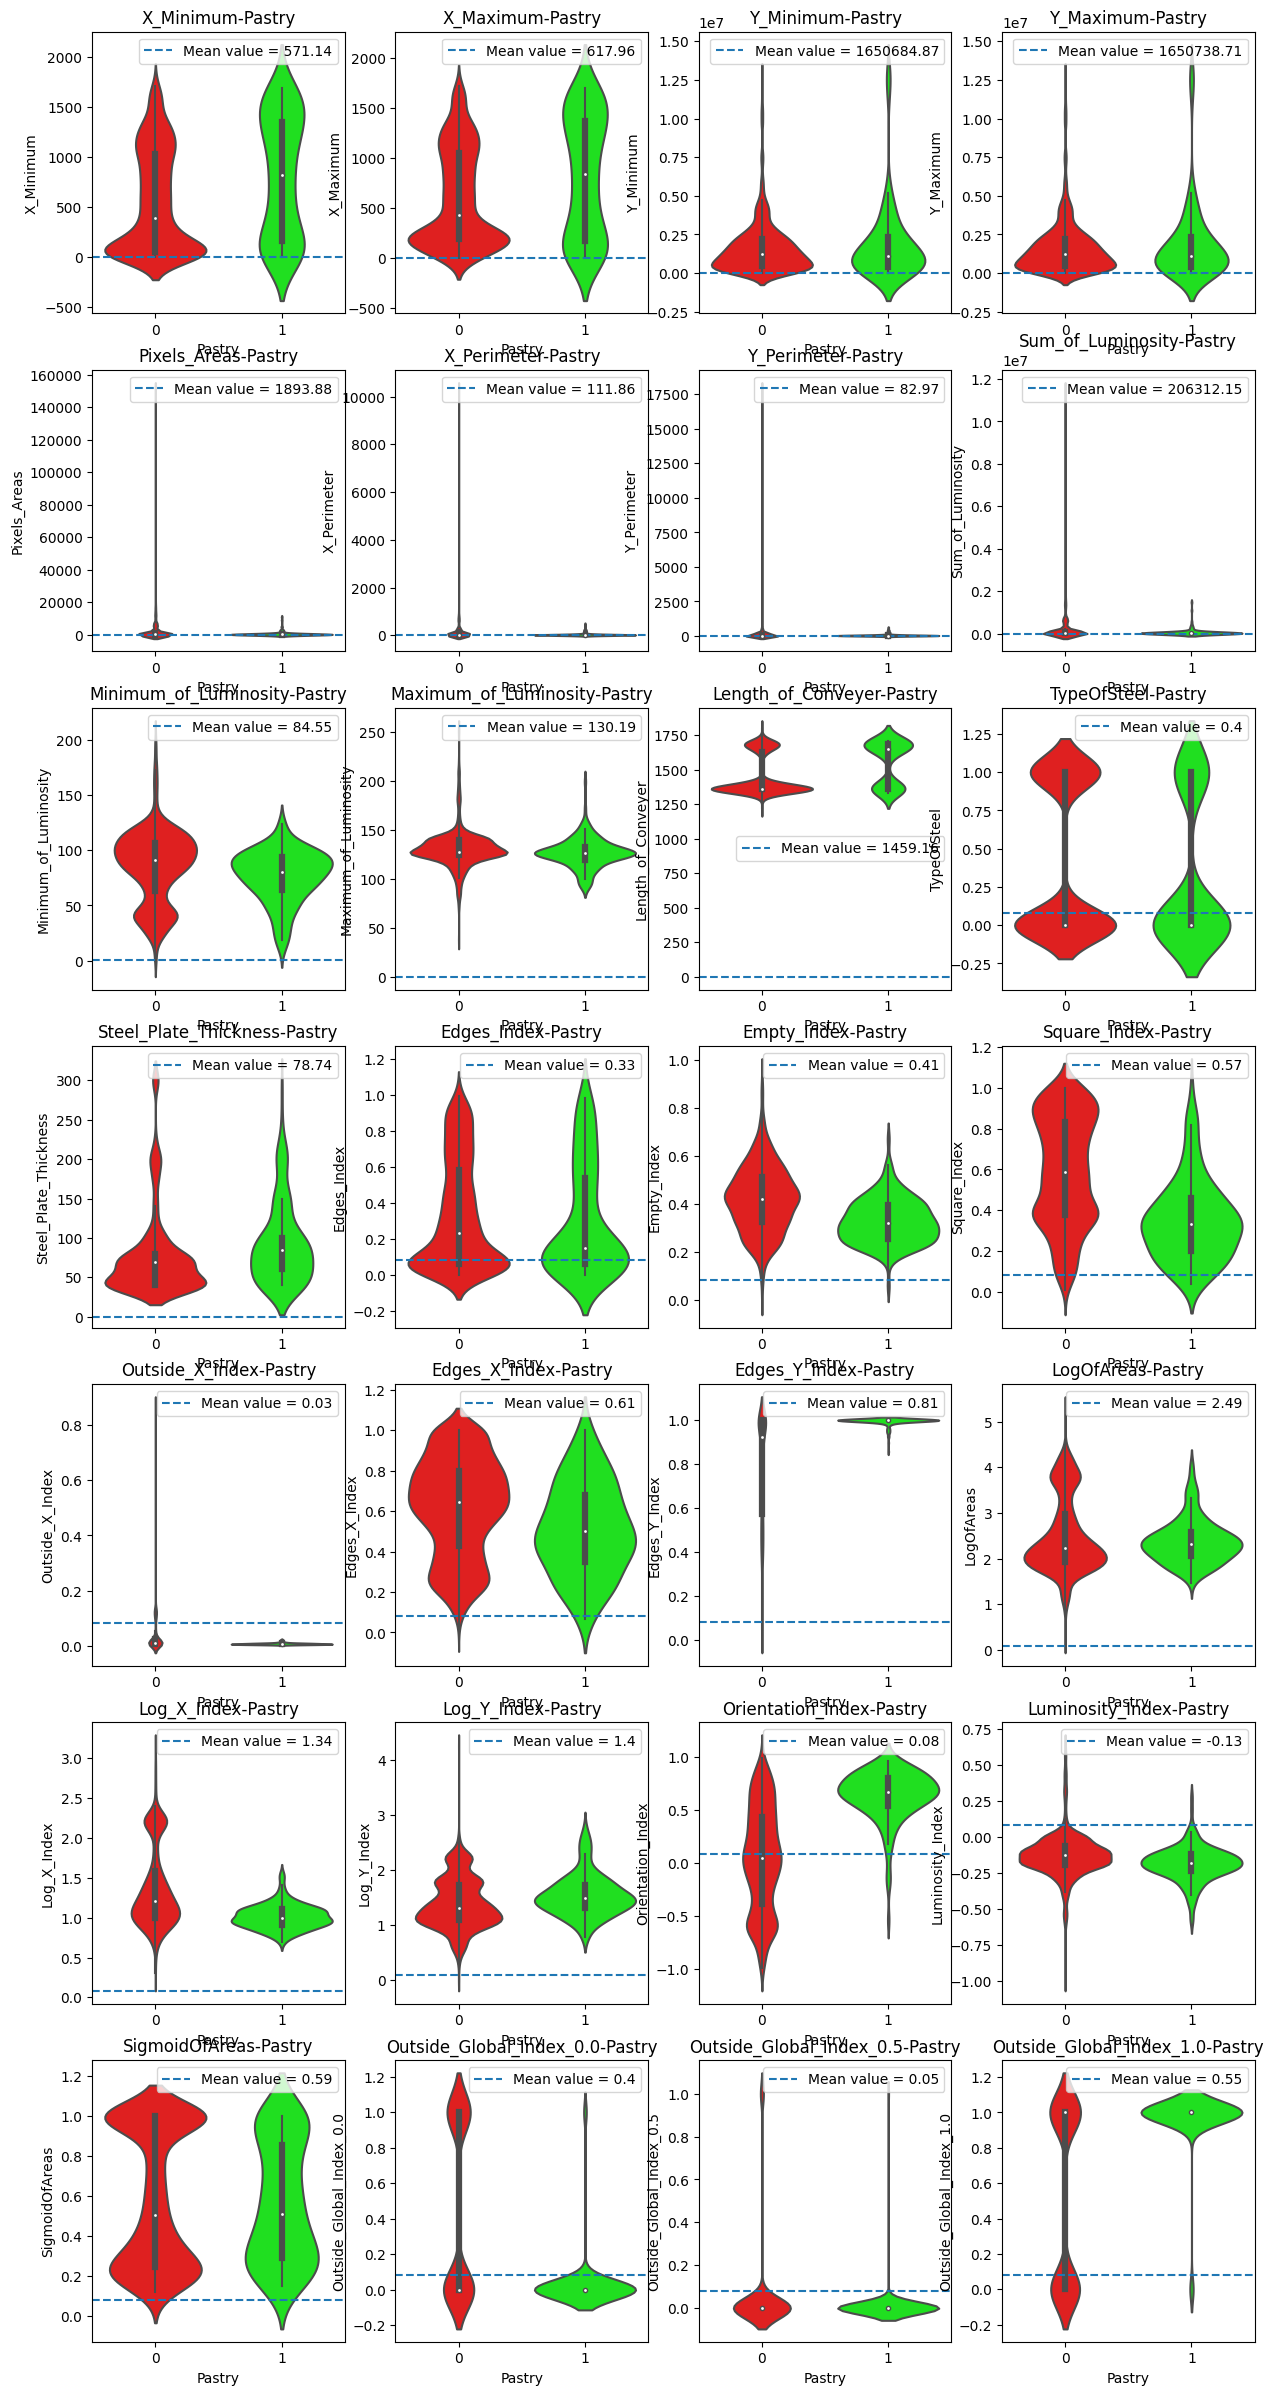

In [42]:

# 특성 - Pastry


features = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel','Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index','Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Outside_Global_Index_0.0',
       'Outside_Global_Index_0.5', 'Outside_Global_Index_1.0']
target = 'Pastry'
plt.figure(figsize=(15,30))
j = 0
for i in features:
       plt.subplot(7,4,j+1)
       sns.violinplot(x=df_encoded[target],y=df_encoded[i],palette=["red","lime"])
       plt.title(f'{i}-{target}')
       plt.axhline(df_encoded[target].mean(),linestyle = "dashed", label ="Mean value = " + str(round(df_encoded[i].mean(), 2)))
       plt.legend(loc="best")
       j = j + 1

In [41]:
# 특성 - K_Scatch


features = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel','Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index','Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Outside_Global_Index_0.0',
       'Outside_Global_Index_0.5', 'Outside_Global_Index_1.0']
target = 'K_Scatch'
plt.figure(figsize=(15,30))
j = 0
for i in features:
       plt.subplot(7,4,j+1)
       sns.violinplot(x=df_encoded[target],y=df_encoded[i],palette=["red","lime"])
       plt.title(f'{i}-{target}')
       plt.axhline(df_encoded[target].mean(),linestyle = "dashed", label ="Mean value = " + str(round(df_encoded[i].mean(), 2)))
       plt.legend(loc="best")
       j = j + 1

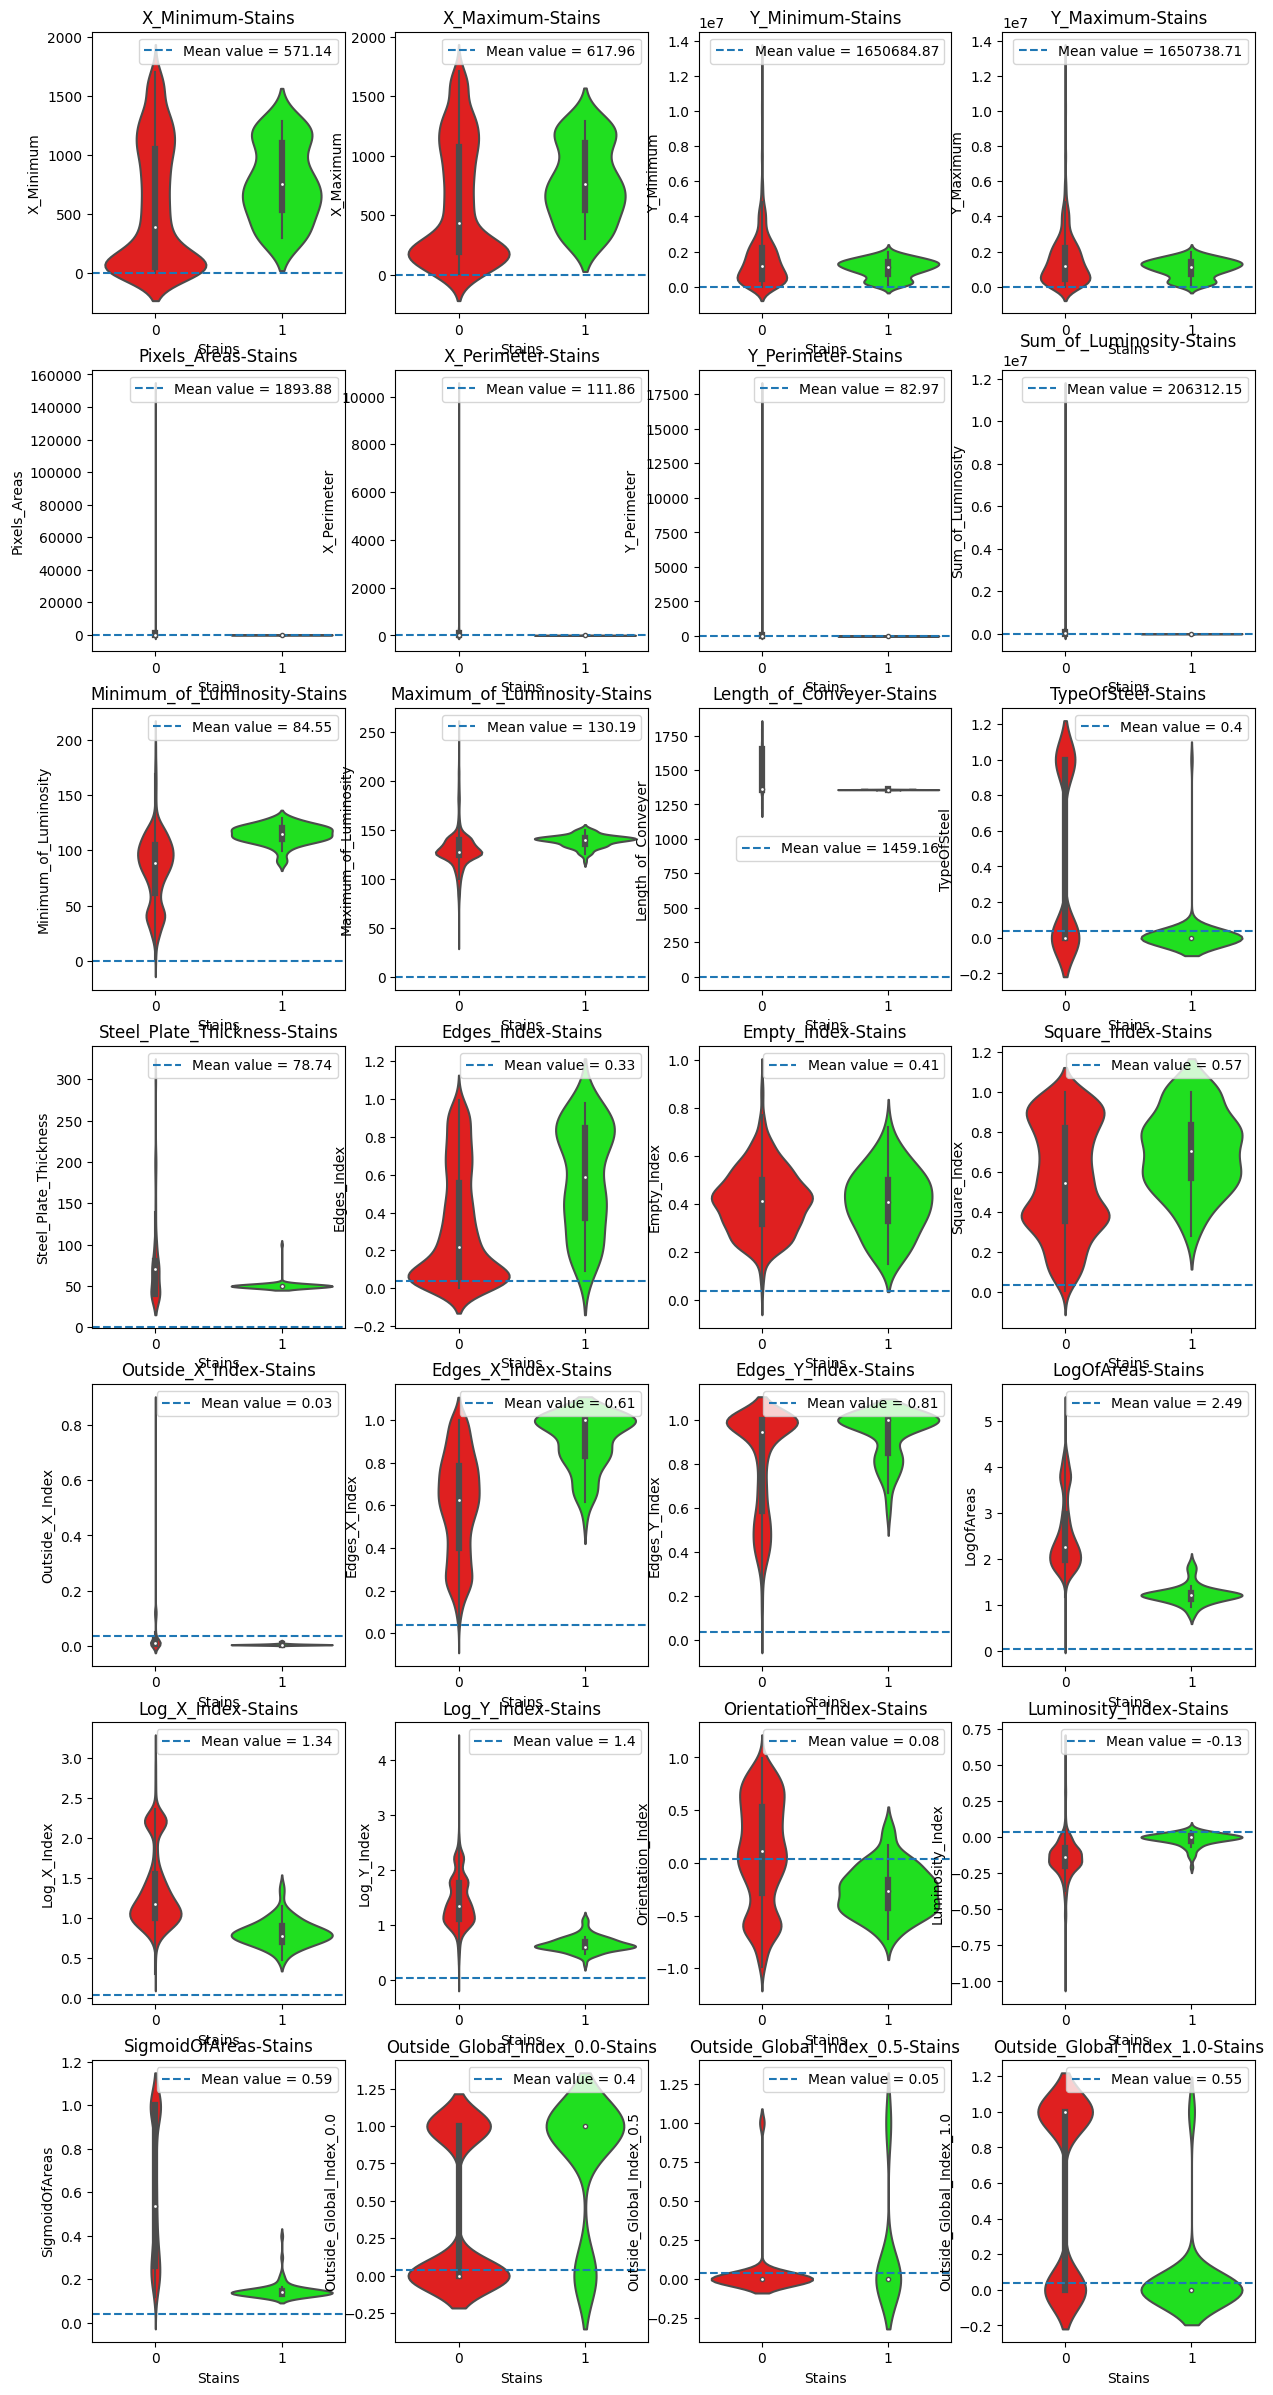

In [40]:
# 특성 - Stains 


features = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel','Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index','Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Outside_Global_Index_0.0',
       'Outside_Global_Index_0.5', 'Outside_Global_Index_1.0']
target = 'Stains'
plt.figure(figsize=(15,30))
j = 0
for i in features:
       plt.subplot(7,4,j+1)
       sns.violinplot(x=df_encoded[target],y=df_encoded[i],palette=["red","lime"])
       plt.title(f'{i}-{target}')
       plt.axhline(df_encoded[target].mean(),linestyle = "dashed", label ="Mean value = " + str(round(df_encoded[i].mean(), 2)))
       plt.legend(loc="best")
       j = j + 1

In [39]:
# 특성 - Dirtiness


features = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel','Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index','Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Outside_Global_Index_0.0',
       'Outside_Global_Index_0.5', 'Outside_Global_Index_1.0']
target = 'Dirtiness'
plt.figure(figsize=(15,30))
j = 0
for i in features:
       plt.subplot(7,4,j+1)
       sns.violinplot(x=df_encoded[target],y=df_encoded[i],palette=["red","lime"])
       plt.title(f'{i}-{target}')
       plt.axhline(df_encoded[target].mean(),linestyle = "dashed", label ="Mean value = " + str(round(df_encoded[i].mean(), 2)))
       plt.legend(loc="best")
       j = j + 1

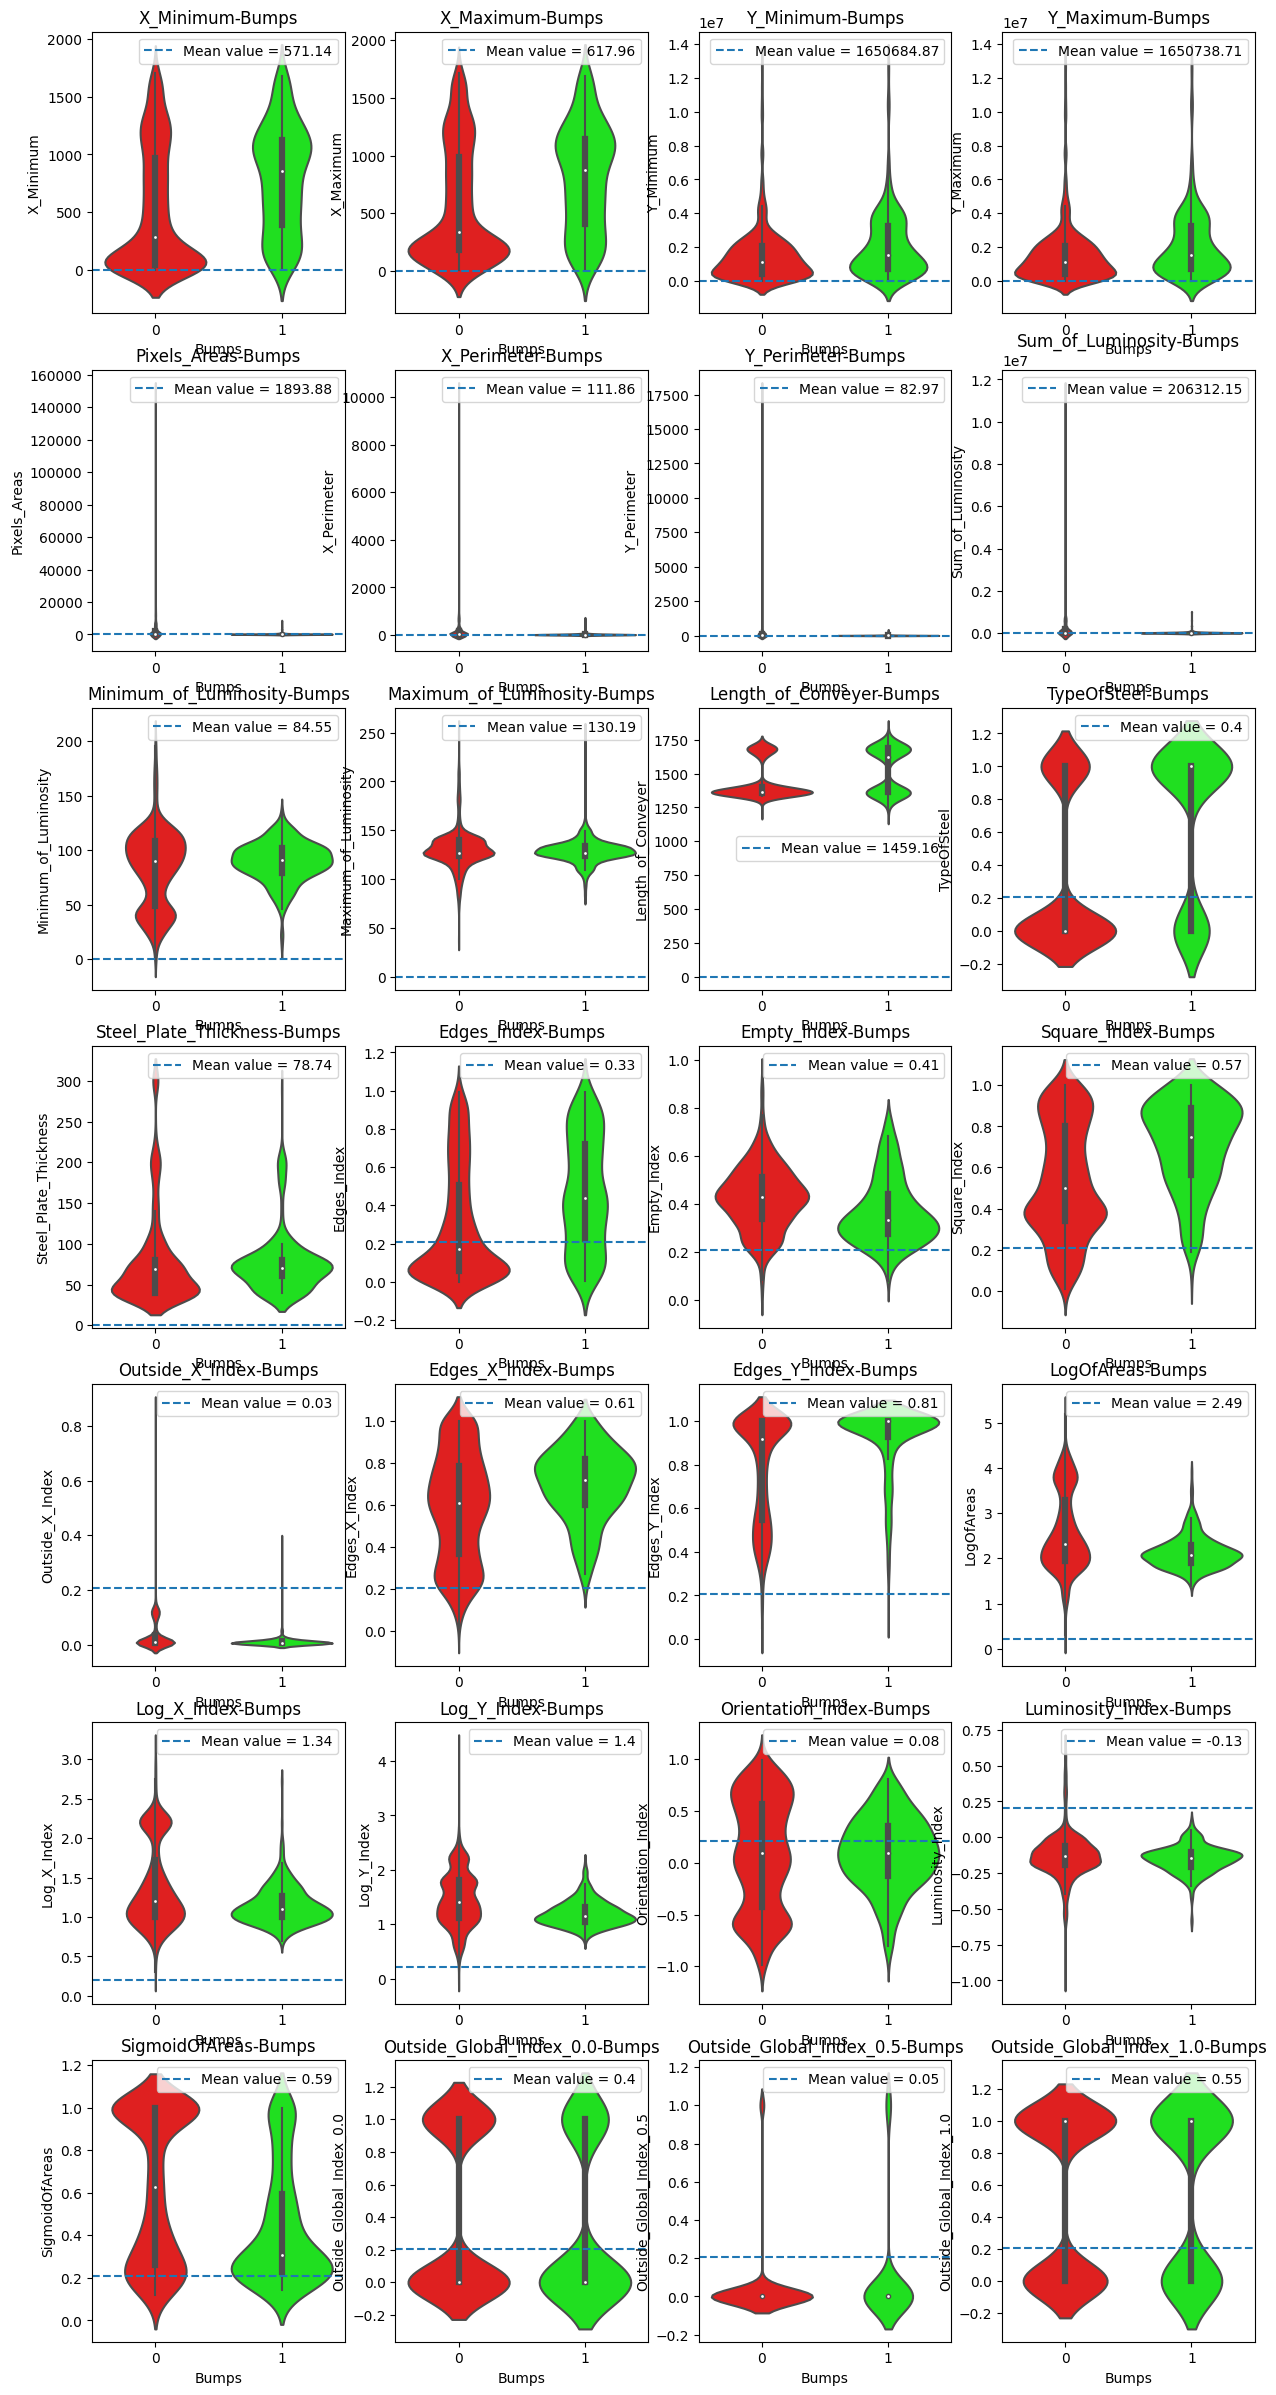

In [38]:
# 특성 - Bumps


features = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel','Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index','Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Outside_Global_Index_0.0',
       'Outside_Global_Index_0.5', 'Outside_Global_Index_1.0']
target = 'Bumps'
plt.figure(figsize=(15,30))
j = 0
for i in features:
       plt.subplot(7,4,j+1)
       sns.violinplot(x=df_encoded[target],y=df_encoded[i],palette=["red","lime"])
       plt.title(f'{i}-{target}')
       plt.axhline(df_encoded[target].mean(),linestyle = "dashed", label ="Mean value = " + str(round(df_encoded[i].mean(), 2)))
       plt.legend(loc="best")
       j = j + 1

In [37]:
# 특성 - Other_Faults


features = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel','Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index','Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Outside_Global_Index_0.0',
       'Outside_Global_Index_0.5', 'Outside_Global_Index_1.0']
target = 'Other_Faults'
plt.figure(figsize=(15,20))
j = 0
for i in features:
       plt.subplot(7,4,j+1)
       sns.violinplot(x=df_encoded[target],y=df_encoded[i],palette=["red","lime"])
       plt.title(f'{i}-{target}')
       plt.axhline(df_encoded[target].mean(),linestyle = "dashed", label ="Mean value = " + str(round(df_encoded[i].mean(), 2)))
       plt.legend(loc="best")
       j = j + 1

In [44]:

# 이상치를 클리핑으로 처리
for Feature in df_encoded.columns:
    # IQR을 이용하여 이상치 확인 및 처리
    Q1 = df_encoded[Feature].quantile(0.25)
    Q3 = df_encoded[Feature].quantile(0.75)
    IQR = Q3 - Q1

    # 이상치 확인
    outliers = df_encoded[(df_encoded[Feature] < Q1 - 1.5 * IQR) | (df_encoded[Feature] > Q3 + 1.5 * IQR)]
    print("이상치 확인:")
    print(outliers)

    # 이상치 처리 (이상치를 하한값 혹은 상한값으로 대체)
    line_down = df_encoded[Feature].quantile(0.25) - IQR * 1.5
    line_up = df_encoded[Feature].quantile(0.75) + IQR * 1.5
    df_encoded[Feature] = df_encoded[Feature].clip(line_down, line_up)

이상치 확인:
Empty DataFrame
Columns: [X_Minimum, X_Maximum, Y_Minimum, Y_Maximum, Pixels_Areas, X_Perimeter, Y_Perimeter, Sum_of_Luminosity, Minimum_of_Luminosity, Maximum_of_Luminosity, Length_of_Conveyer, Steel_Plate_Thickness, Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, LogOfAreas, Log_X_Index, Log_Y_Index, Orientation_Index, Luminosity_Index, SigmoidOfAreas, Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults, TypeOfSteel, Outside_Global_Index_0.0, Outside_Global_Index_0.5, Outside_Global_Index_1.0]
Index: []

[0 rows x 35 columns]
이상치 확인:
Empty DataFrame
Columns: [X_Minimum, X_Maximum, Y_Minimum, Y_Maximum, Pixels_Areas, X_Perimeter, Y_Perimeter, Sum_of_Luminosity, Minimum_of_Luminosity, Maximum_of_Luminosity, Length_of_Conveyer, Steel_Plate_Thickness, Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, LogOfAreas, Log_X_Index, Log_Y_Index, Orientation_Index, Luminosity_Index, SigmoidOfAreas,

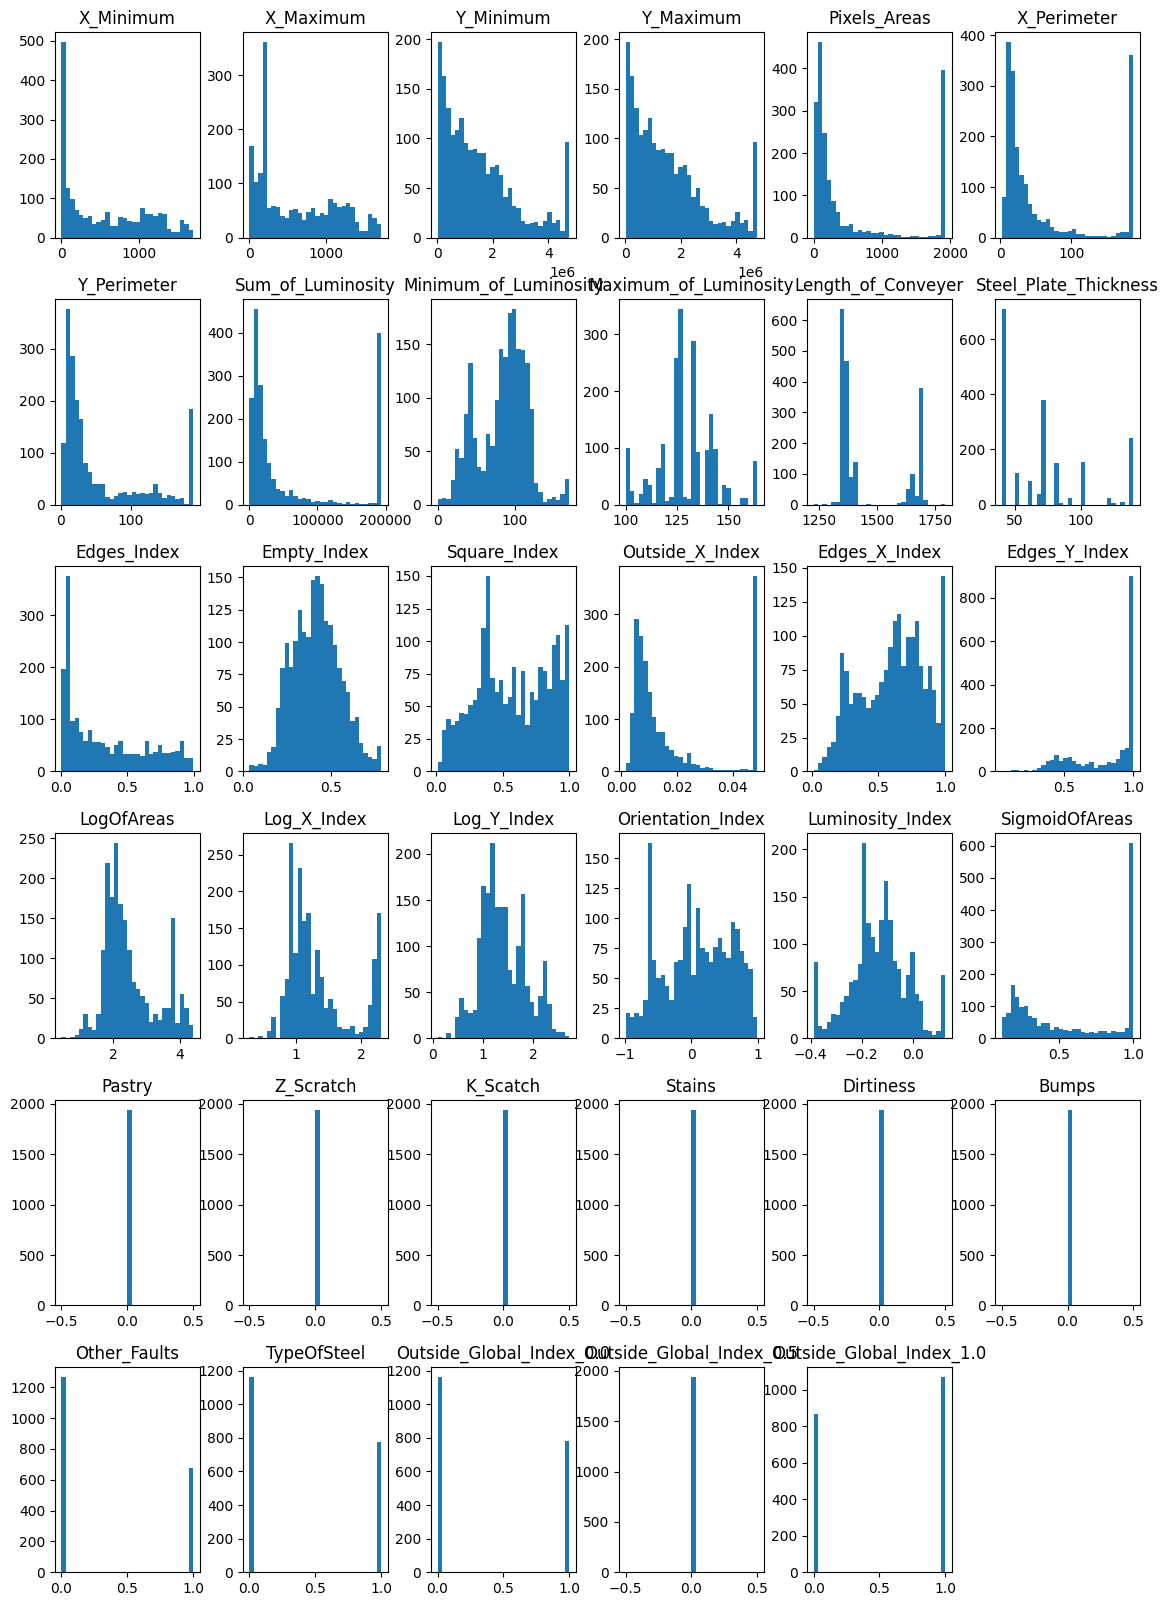

In [45]:
# 클리핑후 데이터 분포 확인
df_encoded.hist(bins=30, figsize=(14,20), grid=False)
plt.show()

In [82]:
# Import the necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load the data
data = pd.read_csv('./csv/multi_classification_data.csv')

# Drop the 'TypeOfSteel_A400' column
data = data.drop(['TypeOfSteel_A400'], axis=1)

# Perform one-hot encoding on the 'Outside_Global_Index' column
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(data[['Outside_Global_Index']])
df_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(['Outside_Global_Index']))
data = pd.concat([data, df_encoded], axis=1)
data = data.drop('Outside_Global_Index', axis=1)

# Handle outliers by clipping to the 1.5 IQR range
for Feature in data.columns:
    Q1 = data[Feature].quantile(0.25)
    Q3 = data[Feature].quantile(0.75)
    IQR = Q3 - Q1
    line_down = data[Feature].quantile(0.25) - IQR * 1.5
    line_up = data[Feature].quantile(0.75) + IQR * 1.5
    data[Feature] = data[Feature].clip(line_down, line_up)

# Standardize the data
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Split the data into features and targets
features_scaled = data_scaled.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], axis=1)
targets_with_other = data_scaled[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, targets_with_other.idxmax(axis=1), test_size=0.2, random_state=42, stratify=targets_with_other.idxmax(axis=1))

# Define a Gradient Boosting classifier with GridSearchCV for hyperparameter tuning
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate the classification report
report = classification_report(y_test, y_pred)
print(report)


c:\ProgramData\anaconda3\envs\TeamProject\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\ProgramData\anaconda3\envs\TeamProject\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
423360 fits failed out of a total of 846720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
232795 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\TeamProject\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_trai

              precision    recall  f1-score   support

Other_Faults       0.78      0.44      0.56       135
      Pastry       0.76      0.93      0.84       254

    accuracy                           0.76       389
   macro avg       0.77      0.69      0.70       389
weighted avg       0.76      0.76      0.74       389



c:\ProgramData\anaconda3\envs\TeamProject\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.65334988 0.65334988 0.65334988 ...        nan        nan        nan]
  warnings.warn(
